In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time 
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from google.colab import files

In [0]:
!pip install catboost
from catboost import CatBoostRegressor

In [0]:
!pip install lightgbm --install-option=--gpu
import lightgbm as lgb

In [0]:
# RMSLE in natural log 
def my_loss(pred, actual):
  assert len(pred) == len(actual)
  error2 = [(math.log(pred[i] + 1) - math.log(actual[i] - 1))**2 for i in range(len(pred))]
  result = np.sqrt(np.sum(error2) / len(pred))
  return result 

In [0]:
def get_loss(pred, actual):
  log_mse = mean_squared_error(np.log1p(pred), np.log1p(actual))
  result = np.sqrt(log_mse)
  return result 

In [0]:
def get_loss(pred, actual):
  return np.sqrt(mean_squared_error(actual, pred))

In [0]:
seed = 2019  #42  #36

## Load the data

In [0]:
# Import the all dataset
tr = pd.read_csv('train_3.csv')
te = pd.read_csv('test_3.csv')

In [0]:
print("NAs in train set\n", tr.isnull().sum()[tr.isnull().sum() != 0])
print("NAs in test set\n", te.isnull().sum()[te.isnull().sum() != 0])

NAs in train set
 n_crew_profile    16
dtype: int64
NAs in test set
 n_crew_profile         22
r_rating_totalVotes     1
dtype: int64


In [0]:
# Fill in NA
tr.n_crew_profile.fillna(0, inplace = True)
te.n_crew_profile.fillna(0, inplace = True)

In [0]:
te.r_rating_totalVotes.fillna(0, inplace = True)

In [0]:
y = tr.revenue_log
X = tr.drop('revenue_log', axis = 1)

In [0]:
# Split into train and Valid set
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = .2, random_state = seed)

In [0]:
print("The size of the train set ", X_tr.shape)
print("The size of the validation set ", X_val.shape)
print("The size of the test set ", te.shape)

The size of the train set  (2400, 376)
The size of the validation set  (600, 376)
The size of the test set  (4398, 376)


In [0]:
#del tr, X, y, 

In [0]:
df = pd.DataFrame()
df['val'] = y_val

In [0]:
tr.iloc[:, :50].describe()

,budget_log,popularity_log,runtime_h,runtime_log,runtime_m,status,is_collection,is_homepage,n_genres,n_prod_count,n_prod_comp,n_spoken_lang,cast_male,crew_male,n_crew_profile,year,month,day,weekofday,rating,n_cast_log,n_crew_log,popularity2_log,totalVotes_log,popularity_diff_log,r_runtime_rating,r_rating_totalVotes,r_budget_rating,r_popularity_totalVotes,r_popularity_rating,r_popularity_ngenres,r_popularity_n_cast,r_budget_totalVotes,r_budget_runtime,r_budget_year,r_totalVotes_year,r_rating_year,r_rating_year2,m_rating_totalVotes,m_year_popularity,m_year_budget,m_year_totalVotes_log,m_year_rating,m_year_runtime,m_year_n_crew_log,m_weekofday_budget,_genres_Action,_genres_Adventure,_genres_Animation,_genres_Biography
count,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.0
mean,11.961359,1.975396e+00,1.239667,4.655350,-0.022999,1.001333,0.201333,0.315333,2.508000,1.351333,2.836667,1.459000,0.229156,0.091542,0.295459,1999.713000,6.775333,15.046333,3.269333,6.115900,2.845370,2.749341,2.004640,5.406852,0.297523,-0.074844,0.099161,3.885689e+06,3.431457,0.502601,3.988243e+00,6.263061e-01,8.985388e+04,2.116568e+05,2.706289e+05,0.074753,0.003059,0.088497,5.410665,8.512923,2.273950e+07,5.411259,6.115438,-0.001121,20.927257,2.246283e+07,0.247333,0.146667,0.047000,0.0
std,7.403049,7.416869e-01,0.467225,0.366837,1.002196,0.036497,0.401063,0.464726,1.111612,0.738521,2.004660,0.880479,0.148918,0.121399,0.241018,15.423313,3.409115,8.632981,1.306150,1.512808,0.688958,0.998875,0.603624,1.920214,0.247254,1.929844,0.341104,1.586896e+07,1.366334,1.273596,5.281556e+00,5.594107e+00,7.719017e+05,4.255145e+05,4.203517e+05,0.129112,0.000760,0.167192,1.108702,3.255377,9.703793e+06,0.479286,0.298785,0.140038,3.712599,6.432693e+06,0.431534,0.353832,0.211674,0.0
min,0.000000,9.999995e-07,0.000000,0.000000,-2.177292,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1921.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.470004,0.693147,0.000195,-21.772921,0.000000,0.000000e+00,-2.113439,0.000010,2.500000e-07,5.000000e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.007220,0.000000,0.000000,0.690821,0.417895,1.248674e+05,2.215812,5.611607,-1.854838,9.200000,1.549484e+07,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.613042e+00,1.000000,4.553877,-0.565022,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.125000,0.000000,0.117647,1993.000000,4.000000,8.000000,2.000000,5.800000,2.484907,2.197225,1.716362,4.189655,0.117776,-0.107095,0.005911,0.000000e+00,2.574760,0.265571,1.558928e+00,2.048711e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.053036,0.002877,0.066667,5.408077,7.412260,1.324143e+07,5.126734,5.942373,-0.052490,19.090909,1.732969e+07,0.000000,0.000000,0.000000,0.0
50%,15.894952,2.125233e+00,1.000000,4.653960,0.144376,1.000000,0.000000,0.000000,2.000000,1.000000,2.000000,1.000000,0.208333,0.058397,0.240000,2004.000000,7.000000,15.000000,4.000000,6.400000,2.833213,2.708050,2.112755,5.575949,0.241470,0.021875,0.019385,1.232877e+06,3.409988,0.332031,2.969959e+00,3.784846e-01,2.002506e+04,7.450112e+04,1.052632e+05,0.069764,0.003179,0.076250,5.593403,7.815993,2.664833e+07,5.489345,6.060645,0.001543,20.035370,1.732969e+07,0.000000,0.000000,0.000000,0.0
75%,17.216708,2.475780e+00,1.000000,4.779123,0.724793,1.000000,0.000000,1.000000,3.000000,1.000000,4.000000,2.000000,0.327691,0.136676,0.409091,2011.000000,10.000000,22.000000,4.000000,7.000000,3.218876,3.367

## Validation Set

##  Dimension Reduction

In [0]:
svd = TruncatedSVD(n_components=5, random_state = seed)
X_svd = svd.fit(X)
X_svd = pd.DataFrame(X_svd.fit_transform(X))

In [0]:
X_svd.explained_variance_ratio_

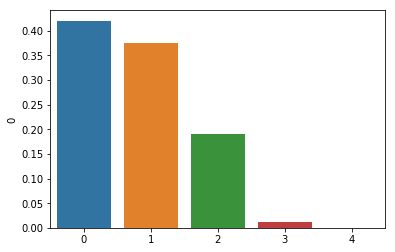

In [0]:
svd_ratio = pd.DataFrame(X_svd.explained_variance_ratio_)
sns.barplot(x = svd_ratio.index, y = svd_ratio[0])

In [0]:
# Split into train and Valid set
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_svd, y, test_size = .2, random_state = seed)

## 1st Layer Modeling

### 1. Elastic-Net

In [0]:
model_el = ElasticNet(alpha = .01, l1_ratio = 0, max_iter = 5000)
model_el.fit(X_tr, y_tr)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
pred_el = model_el.predict(X_val)
get_loss(pred_el, y_val)

2.0501962630668777

In [0]:
# 1st try: 2.1347
# 2nd try: 2.1266
# 3rd try: 2.0524 (Mean encoding)
# 6th try: 1.9977

In [0]:
df['el'] = pred_el

In [0]:
pred = model_el.predict(te)

### 2. KNN 

In [0]:
model_knn = KNeighborsRegressor(n_neighbors = 20, 
                                weights = 'distance', 
                                p = 1)  

model_knn.fit(X_tr, y_tr)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=20, p=1,
          weights='distance')

In [0]:
pred_knn = model_knn.predict(X_val)
get_loss(pred_knn, y_val)

2.468232212737805

In [0]:
# 3rd try: 2.1707 (Mean encoding)
# 6th try: 2.5185

In [0]:
df['knn'] = pred_knn

### Random Forest

In [0]:
model_rf = RandomForestRegressor(n_estimators = 5000, 
                                 criterion = 'mse',
                                 #min_samples_split = .05,
                                 #min_samples_leaf = 50,
                                 max_depth = 11)

model_rf.fit(X_tr, y_tr)
pred_rf = model_rf.predict(X_val)
get_loss(pred_rf, y_val)

1.9540237028206302

In [0]:
# 6th try: 1.9388

In [0]:
df['rf'] = pred_rf

In [0]:
model_rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

### 3. Kernel SVM

In [0]:
# scaling?

In [0]:
model_svm = SVR(kernel = 'rbf')  
model_svm.fit(X_tr, y_tr)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
pred_svm = model_svm.predict(X_val)
get_loss(y_val, pred_knn)

2.468232212737805

In [0]:
# 3rd try: 2.1707 (Mean encoding)
# 6th try: 2.5185

In [0]:
df['svm'] = pred_svm

### 4. Xgboost

In [0]:
#with open('model_xg.pkl', 'rb') as file:  
#    model_xg = pickle.load(file)

In [0]:
model_xg = xgb.XGBRegressor(objective = 'reg:linear',
                            n_estimators = 3000, 
                            max_depth = 11, 
                            learning_rate = 0.01,
                            early_stopping_rounds = 500,
                            gamma = 1.0,
                            #alpha = .6,
                            subsample = 0.7,   
                            colsample_bytree = 0.6, 
                            colsample_bylevel = 0.5,
                            silent = True)

In [0]:
model_xg.fit(X_tr, y_tr)
    
pred_xg = model_xg.predict(X_val)
get_loss(y_val, pred_xg)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1.8330248665267113

In [0]:
# 1st try: 1.9202
# 2nd try: 1.9128
# 3nd try: 1.8978
# 4th try: 1.8791 (Mean encoding)
# 5th try: 1.8439 (+ Voting Data)
# 6th try: 1.8360 (2nd Mean encoding)   

In [0]:
param_save = model_xg.get_params
param_save

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
       colsample_bytree=0.6, early_stopping_rounds=500, gamma=1.0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)>

In [0]:
df['xg'] = pred_xg

In [0]:
# Save the model
filename = 'model_xg.pkl'
with open(filename, 'wb') as file:
  pickle.dump(model_xg, file)

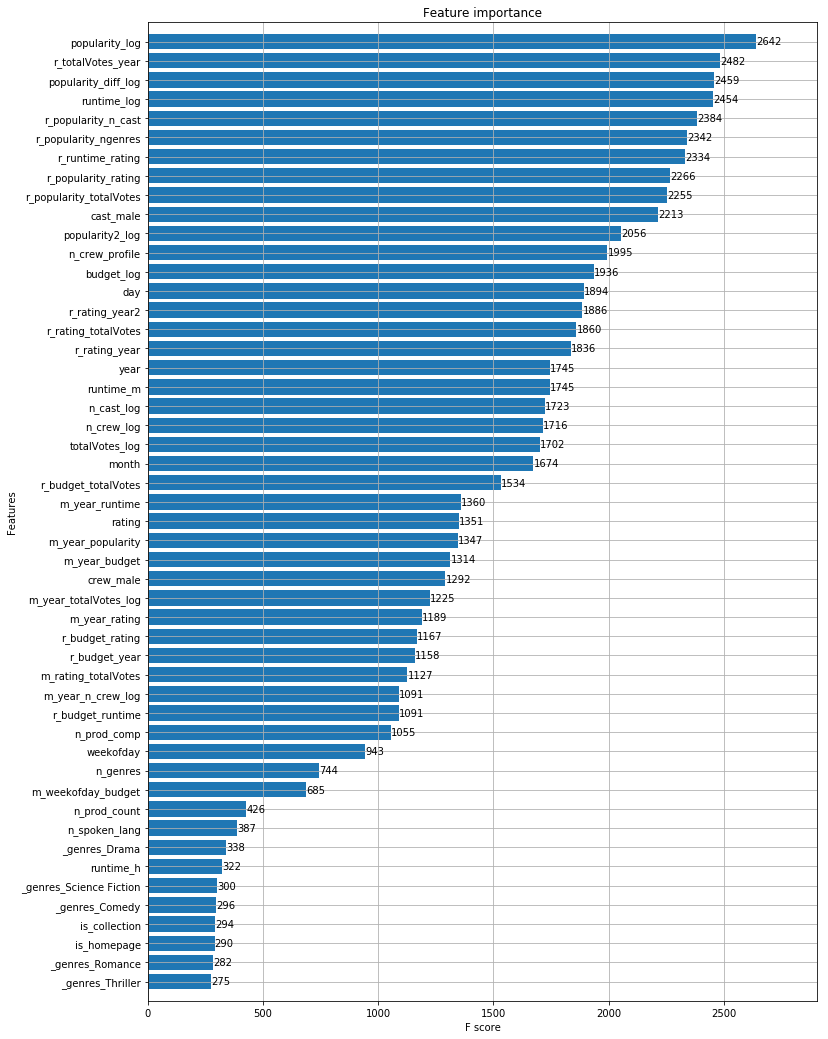

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model_xg, max_num_features= 50, height=0.8, ax=ax)
plt.show()

In [0]:
#cols = X_tr.columns[model_xg.feature_importances_ > .005]
#print("The number of cols ", len(cols))
#print("Columns: ", cols)

### 5. Catboost

In [0]:
with open('model_cb.pkl', 'rb') as file:  
    model_cb = pickle.load(file)

In [0]:
#time_start = time.time()
model_cb = CatBoostRegressor(bagging_temperature = 0.2,
                             colsample_bylevel = 0.7,
                             depth = 9,
                             early_stopping_rounds = 500,
                             eval_metric = 'RMSE',
                             iterations = 3000,
                             learning_rate = .05,
                             logging_level = 'Silent')

model_cb.fit(X_tr, y_tr, eval_set = (X_val, y_val), use_best_model = True)
#time_end = time.time()
#print("Time duration: {}min".format((time_end-time_start)/60))

In [0]:
pred_cb = model_cb.predict(X_val)
get_loss(y_val, pred_cb)

1.8444349666198014

In [0]:
# 1st try: 1.9218
# 2nd try: 1.8779
# 3rd try: 1.8753
# 4th try: 1.8618 (Mean encoding)
# 5th try: 1.8268 (+ Voting Data)
# 6th try: 1.8570 (2nd Mean encoding)

In [0]:
model_cb.get_params()

{'bagging_temperature': 0.5,
 'colsample_bylevel': 0.8,
 'depth': 9,
 'early_stopping_rounds': 500,
 'eval_metric': 'RMSE',
 'iterations': 3000,
 'learning_rate': 0.05,
 'logging_level': 'Silent',
 'loss_function': 'RMSE'}

In [0]:
df['cb'] = pred_cb

In [0]:
# Save the model
filename = 'model_cb.pkl'
with open(filename, 'wb') as file:
  pickle.dump(model_cb, file)

### 6. Lightgbm

In [0]:
tr_data = lgb.Dataset(X_tr, label = y_tr)
val_data = lgb.Dataset(X_val, label = y_val)

params = {'objective' : 'regression',
          'num_iterations' : 5000, 
          'max_depth' : 9, 
          'num_leaves' : 100, 
          'learning_rate': 0.005, 
          'metric' : 'rmse',
          'min_data_in_leaf' : 100, 
          'colsample_bytree': 0.5, 
          'subsample_freq': 1,  
          'lambda_l1' : 0.01, 
          'lambda_l2' : 0.7, 
          'subsample' : 0.8, 
          'verbose' : -1}

hist = {}
model_lg = lgb.train(params, tr_data, 
                     valid_sets = [val_data],
                     verbose_eval = -1, 
                     early_stopping_rounds = 500,
                     callbacks = [lgb.record_evaluation(hist)])

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[4884]	valid_0's rmse: 1.89838


In [0]:
pred_lg = model_lg.predict(X_val, num_iteration = model_lg.best_iteration)
get_loss(pred_lg, y_val)

1.8983776742874539

In [0]:
# 1st try: 
# 2nd try: 1.9138
# 3rd try: 1.9008 (Mean encoding)
# 5th try: 1.8738 (+ Voting Data)
# 6th try: 1.8547 (+ Voting Data)   #1.8681

In [0]:
model_lg.params

{'colsample_bytree': 0.5,
 'lambda_l1': 0.01,
 'lambda_l2': 0.7,
 'learning_rate': 0.005,
 'max_depth': 9,
 'metric': 'rmse',
 'min_data_in_leaf': 100,
 'num_leaves': 100,
 'objective': 'regression',
 'subsample': 0.8,
 'subsample_freq': 1,
 'verbose': -1}

In [0]:
df['lg'] = pred_lg

### 7. Keras

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

In [0]:
print(X_tr.shape[1])
print(X_tr.shape[1] /2)

376
188.0


In [0]:
# initialize the model
model = Sequential()

# create hidden layers
model.add(Dense(input_dim = X_tr.shape[1], output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(output_dim = 32, activation = 'relu'))
model.add(Dropout(.5))
model.add(BatchNormalization())
model.add(Dense(output_dim = 1)) 

# compile: stochastic gradient descent
# Adam(lr = .05)     # RMSprop(lr=0.01)     # SGD(lr=0.01)
my_optimizer = Adam(lr = .05)
model.compile(optimizer = my_optimizer, loss = 'mse', metrics = ['mean_squared_error'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=376, activation="relu", units=128)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # Remove the CWD from sys.path while we load stuff.


In [0]:
# early stopper 
early_stopper = EarlyStopping(patience = 3)

r = model.fit(X_tr, y_tr, 
              validation_data = (X_val, y_val),
              batch_size = 100, 
              nb_epoch = 100,
              callbacks = [early_stopper])

Train on 2400 samples, validate on 600 samples
Epoch 1/100
2400/2400 [==============================] - 0s 72us/step - loss: 5.8717 - mean_squared_error: 5.8717 - val_loss: 40584798110657200.0000 - val_mean_squared_error: 40584798110657200.0000
Epoch 2/100
 100/2400 [>.............................] - ETA: 0s - loss: 3.4835 - mean_squared_error: 3.4835

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


2400/2400 [==============================] - 0s 74us/step - loss: 5.8093 - mean_squared_error: 5.8093 - val_loss: 251557975420130688.0000 - val_mean_squared_error: 251557975420130688.0000
Epoch 3/100
2400/2400 [==============================] - 0s 70us/step - loss: 6.0558 - mean_squared_error: 6.0558 - val_loss: 191462.0535 - val_mean_squared_error: 191462.0535
Epoch 4/100
2400/2400 [==============================] - 0s 70us/step - loss: 5.9657 - mean_squared_error: 5.9657 - val_loss: 22140.5771 - val_mean_squared_error: 22140.5771
Epoch 5/100
2400/2400 [==============================] - 0s 70us/step - loss: 6.0001 - mean_squared_error: 6.0001 - val_loss: 190562.7967 - val_mean_squared_error: 190562.7967
Epoch 6/100
2400/2400 [==============================] - 0s 69us/step - loss: 6.1437 - mean_squared_error: 6.1437 - val_loss: 51515.9797 - val_mean_squared_error: 51515.9797
Epoch 7/100
2400/2400 [==============================] - 0s 70us/step - loss: 5.8773 - mean_squared_error: 5.877

In [0]:
# prediction 
pred_ke = model.predict(X_val)
get_loss(y_val, pred_ke)

2.3275415000968107

In [0]:
# 1st try : 2.9460
# 2nd try : 2.9338 (Mean Encoding)
# 6th try : 2.4070

In [0]:
lr_vals = [0.01, 0.05, 0.1, 0.2, 0.5]

for lr in lr_vals:
    my_optimizer = RMSprop(lr=0.1)
    model.compile(optimizer = my_optimizer, loss = 'mse', metrics = ['mean_squared_logarithmic_error'])
    model.fit(X_tr, y_tr,
              validation_data = (X_val, y_val),
              batch_size = 100,
              nb_epoch = 1000,
              callbacks = [early_stopper])
    
    print("==========================")
    pred_ke = model.predict(X_val)
    loss = np.sqrt(mean_squared_error(y_val, pred_ke))
    print("Learning Rate: {}, RMSE: {}".format(lr, loss))
    print("==========================")

In [0]:
# plot the error
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'valid loss')
plt.legend()
plt.show()

plt.plot(r.history['mean_squared_logarithmic_error'], label = 'train mse')
plt.plot(r.history['val_mean_squared_logarithmic_error'], label = 'valid mse')
plt.legend()
plt.show()

In [0]:
df['ke'] = pred_ke
model_ke = model

In [0]:
df.sample(10)

,val,el,knn,rf,svm,xg,cb,lg,ke
478,16.914053,16.474836,16.972757,16.792401,16.794649,16.705542,16.584122,16.316659,16.827234
2766,18.842677,17.581455,17.539900,18.363934,16.794649,18.535038,18.373374,18.463448,17.345224
553,16.220795,14.607227,15.205859,15.969402,16.378045,16.325083,15.747567,16.262187,15.121403
1422,17.863536,17.009882,17.274770,16.976439,16.794649,16.891129,17.227585,16.921674,17.586359
69,18.881065,18.648607,18.556509,19.379459,16.794649,19.351385,19.153949,19.033097,17.917591
2182,17.290177,17.248164,18.467800,17.694231,16.794649,17.633377,17.546491,18.028217,17.554319
1625,18.116361,18.066336,17.959950,18.447378,16.794649,18.641039,18.930488,18.399860,17.507528
546,18.477388,17.451281,17.442553,17.895580,16.794649,18.073326,17.606624,18.204972,17.078917
1587,16.559979,16.551127,17.366764,17.189588,16.794649,17.540138,17.230315,17.272597,17.875765
1482,17.943000,17.265708,17.576199,18.128064,16.794649,17.604404,17.034014,17.289981,17.231571


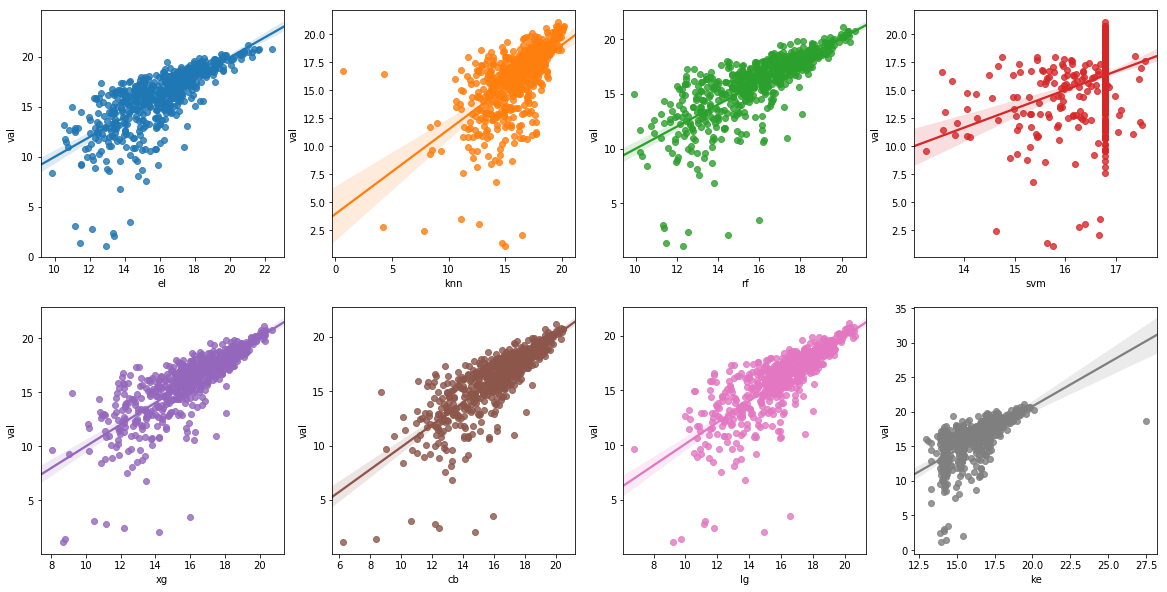

In [0]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))

for i, col in enumerate(df.columns[1:]):
  sns.regplot(x = col, y = 'val', data = df, ax = axes[i//4, i % 4])

In [0]:
te_l1 = pd.DataFrame(columns=['el', 'knn', 'rf', 'svm', 'xg', 'cb', 'lg', 'ke'])
model_list = [model_el, model_knn, model_rf, model_svm,
             model_xg, model_cb, model_lg, model_ke]
for i, model in enumerate(model_list):
    pred = model.predict(te)
    te_l1.iloc[:, i] = pred

In [0]:
te_l1.head()

,el,knn,rf,svm,xg,cb,lg,ke
0,14.292830,17.043637,14.381620,16.878631,16.182156,15.068650,14.924218,14.196903
1,14.052200,15.668532,13.905617,16.794649,12.940205,13.644105,13.511269,15.207811
2,14.907921,15.483239,16.068317,16.022035,16.723972,16.015552,16.722943,14.251155
3,16.220821,14.251724,15.579690,16.794649,15.496733,16.383215,16.038386,16.068937
4,14.722792,14.719828,13.623965,16.794649,13.861198,14.233319,13.580170,14.703863


In [0]:
print("2nd Layer Train: {}".format(df.shape))
print("2nd Layer Test: {}".format(te_l1.shape))

2nd Layer Train: (600, 9)
2nd Layer Test: (4398, 8)


## Save the prediction for Stacking

In [0]:
num = 2
filename = 'stack_train_' + str(num) + '.csv'
df.to_csv(filename, index = False)
files.download(filename)

In [0]:
filename = 'stack_test_' + str(num) + '.csv'
te_l1.to_csv(filename, index = False)
files.download(filename)